# Simple Moving Average (SMA) Optimizer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")
#!pip install pandas_datareader
import pandas_datareader.data as web

### Data Scraping

In [2]:
start= pd.to_datetime('2016-01-01')
end= pd.to_datetime('2021-03-01')

btc = web.DataReader('BTC-USD','yahoo',start, end)
eth = web.DataReader('ETH-USD','yahoo',start, end)
ltc = web.DataReader('LTC-USD','yahoo',start, end)
dash = web.DataReader('DASH-USD','yahoo',start, end)

In [3]:
btc.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900.0,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600.0,433.437988
2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800.0,430.010986
2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500.0,433.091003
2016-01-05,434.182007,429.675995,433.069000,431.959991,34522600.0,431.959991


In [4]:
#eliminando outras colunas para ficar apenas Close
btc.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
eth.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
ltc.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
dash.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
#concatenar para os ativos para 'Close'
df = pd.concat([btc,eth,ltc,dash],axis=1) 
#mudar os headers da colunas
df.columns = ['BTC','ETH','LTC','DASH']

In [5]:
#salvar um um arquivo CSV
df.to_csv("cryptos.csv")

In [6]:
df.BTC.head()

Date
2016-01-01    434.334015
2016-01-02    433.437988
2016-01-03    430.010986
2016-01-04    433.091003
2016-01-05    431.959991
Name: BTC, dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1884 entries, 2016-01-01 to 2021-03-02
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BTC     1884 non-null   float64
 1   ETH     1884 non-null   float64
 2   LTC     1884 non-null   float64
 3   DASH    1884 non-null   float64
dtypes: float64(4)
memory usage: 73.6 KB


### Hands-on

In [8]:
class SMABacktester(): # with ptc 
    ''' Class for the vectorized backtesting of SMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA_S: int
        time window in days for shorter SMA
    SMA_L: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA parameters
        
    test_strategy:
        runs the backtest for the SMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates SMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SMA parameters
    '''
    
    def __init__(self, symbol, SMA_S, SMA_L, start, end, tc):
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA_S"] = raw["price"].rolling(self.SMA_S).mean()
        raw["SMA_L"] = raw["price"].rolling(self.SMA_L).mean()
        self.data = raw
        
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {} | TC = {}".format(self.symbol, self.SMA_S, self.SMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.

        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [9]:
tester_S = SMABacktester("ETH", 50, 200, "2016-01-01", "2021-03-01", 0)

In [10]:
#checando se a fução está ok com dados de inputs
tester_S

SMABacktester(symbol = ETH, SMA_S = 50, SMA_L = 200, start = 2016-01-01, end = 2021-03-01)

In [11]:
#retorno, diferença em relação a buy and hold, número de trade posição (2,2) da matriz
tester_S.test_strategy()

(107.672975,
 -34.129719,
 0.0    1673
 2.0      10
 Name: trades, dtype: int64)

In [12]:
tester_S.results

,price,returns,SMA_S,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2016-07-18,11.619100,0.051633,13.137252,8.935206,1,0.051633,0.0,1.052989,1.052989
2016-07-19,12.450600,0.069119,13.104718,8.992774,1,0.069119,0.0,1.128344,1.128344
2016-07-20,12.650700,0.015944,13.077702,9.051168,1,0.015944,0.0,1.146478,1.146478
2016-07-21,14.661900,0.147540,13.096180,9.119705,1,0.147540,0.0,1.328745,1.328745
2016-07-22,14.299700,-0.025014,13.105240,9.186453,1,-0.025014,0.0,1.295920,1.295920
...,...,...,...,...,...,...,...,...,...
2021-02-25,1475.703735,-0.097342,1493.760579,730.585409,1,-0.097342,0.0,133.736654,101.548307
2021-02-26,1446.033691,-0.020311,1498.167690,735.918013,1,-0.020311,0.0,131.047786,99.506608
2021-02-27,1459.973145,0.009594,1502.883210,741.247942,1,0.009594,0.0,132.311059,100.465830


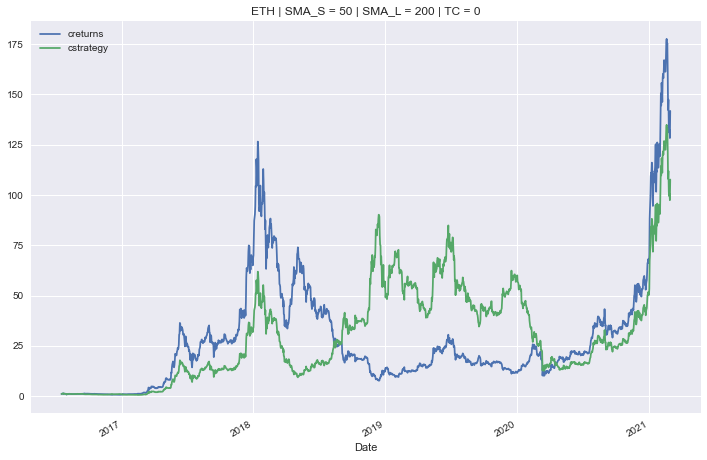

In [13]:
tester_S.plot_results()

In [14]:
#otimizar as médias móveis para o ativo
#apresenta o resultado média curta, média longa, retorno em relação buy and hold
tester_S.optimize_parameters((9, 100, 1), (100, 300, 1))

(array([ 33., 103.]), 2635.944291)

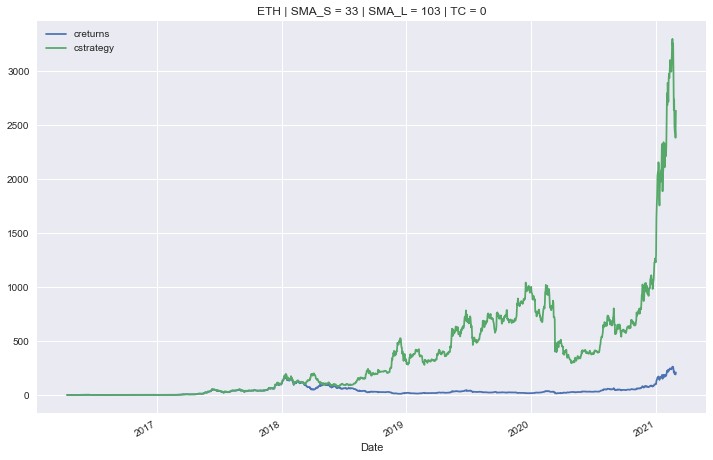

In [15]:
tester_S.plot_results()

In [25]:
tester_S.test_strategy()
#apenas 12 trades

(2635.944291,
 2425.699398,
 0.0    1768
 2.0      12
 Name: trades, dtype: int64)

### Backtesting & Forward Testing

In [16]:
#definir o intervalo de treinamento. Geralmente um pedaço do dataset, 70% em média
train_S = SMABacktester("ETH", 50, 200, "2016-01-01", "2019-10-01", 0)

In [17]:
train_S.optimize_parameters((9, 100, 1), (100, 300, 1)) # optimizing strategy & backtesting ("in-sample")

(array([ 33., 103.]), 707.48112)

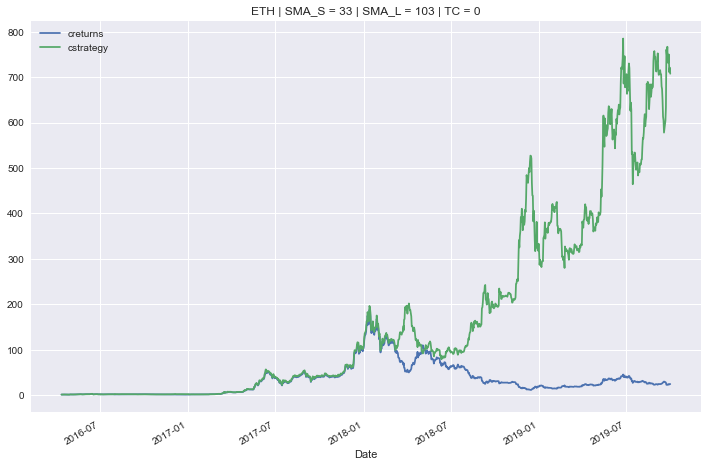

In [18]:
train_S.plot_results()

In [19]:
#agora replicando na outra metade

#AQUI.......... #sma curta e longa tomados dos melhores resultados do treinamento (acima)

#start, end a parte final do dataset

tester_O1 = SMABacktester("ETH", 33, 103, "2019-10-01", "2021-03-01", 0)

In [20]:
tester_O1.test_strategy() # forward testing ("out-sample")

(3.007569,
 -7.718868,
 0.0    407
 2.0      3
 Name: trades, dtype: int64)

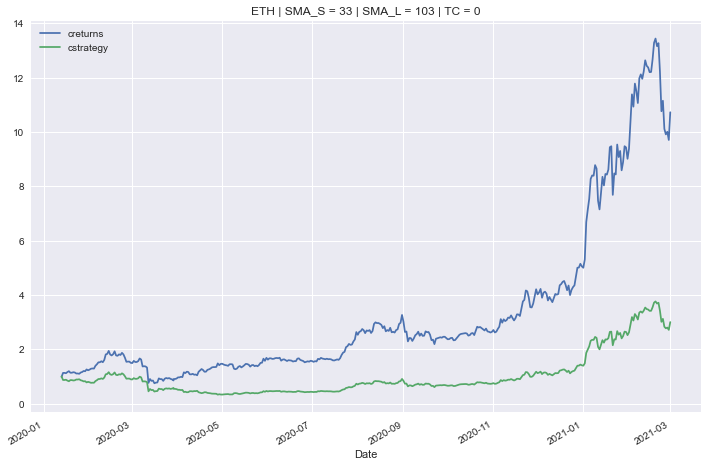

In [21]:
tester_O1.plot_results()
#o resultado da estratégia foi melhor ou pior?
#nesse caso, o resultado foi ruim pois no intervalo cheio estava vindo de um trade já aberto. Por isso, 33, 103 parece idela
#abaixo é apresentado o resultado otimizado para trade começando em 2020

In [22]:
tester_O1.optimize_parameters((9, 100, 1), (100, 300, 1)) # optimizing strategy & backtesting ("in-sample")

(array([ 96., 167.]), 16.967571)

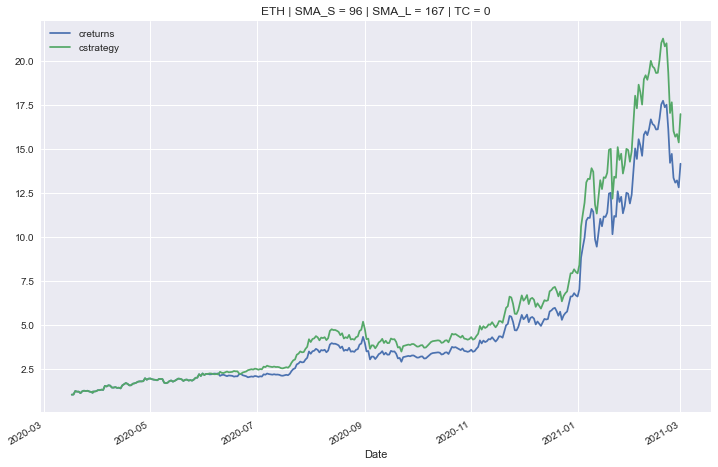

In [23]:
tester_O1.plot_results()

In [24]:
tester_O1.test_strategy()
#apenas 2 trades

(16.967571,
 2.820875,
 0.0    344
 2.0      2
 Name: trades, dtype: int64)

# Exponential Moving Average (EMA) Optimizer

In [26]:
class EMABacktester(): 
    ''' Class for the vectorized backtesting of EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    EMA_S: int
        time window in days for shorter EMA
    EMA_L: int
        time window in days for longer EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new EMA parameters
        
    test_strategy:
        runs the backtest for the EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two EMA parameters
    '''
    
    def __init__(self, symbol, EMA_S, EMA_L, start, end, tc):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "EMABacktester(symbol = {}, EMA_S = {}, EMA_L = {}, start = {}, end = {})".format(self.symbol, self.EMA_S, self.EMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        raw["EMA_L"] = raw["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean() 
        self.data = raw
        
    def set_parameters(self, EMA_S = None, EMA_L = None):
        ''' Updates EMA parameters and resp. time series.
        '''
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA_S"] > data["EMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | EMA_S = {} | EMA_L = {} | TC = {}".format(self.symbol, self.EMA_S, self.EMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, EMA):
        ''' Updates EMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        EMA: tuple
            EMA parameter tuple
        '''
        self.set_parameters(int(EMA[0]), int(EMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA1_range, EMA2_range):
        ''' Finds global maximum given the EMA parameter ranges.

        Parameters
        ==========
        EMA1_range, EMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (EMA1_range, EMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [27]:
tester_E = EMABacktester("ETH", 50, 200, "2016-01-01", "2021-03-01", 0)
tester_E

EMABacktester(symbol = ETH, EMA_S = 50, EMA_L = 200, start = 2016-01-01, end = 2021-03-01)

In [28]:
tester_E.test_strategy()

(20.697061,
 -121.105633,
 0.0    1673
 2.0      10
 Name: trades, dtype: int64)

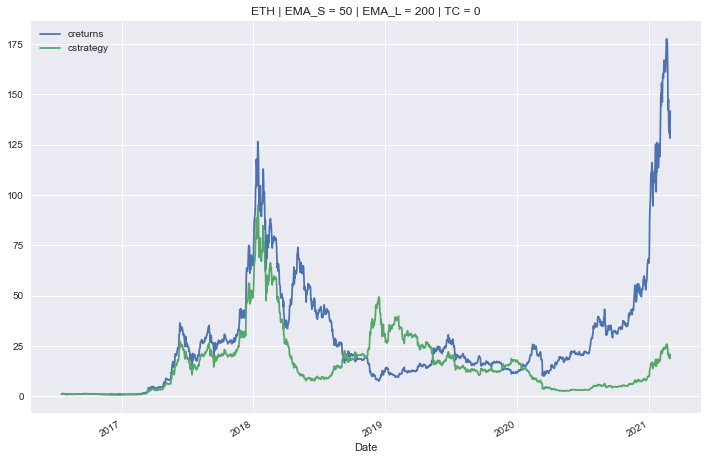

In [29]:
tester_E.plot_results()
#shit

In [30]:
tester_E.optimize_parameters((9, 100, 1), (100, 300, 1))

(array([ 11., 122.]), 1609.12761)

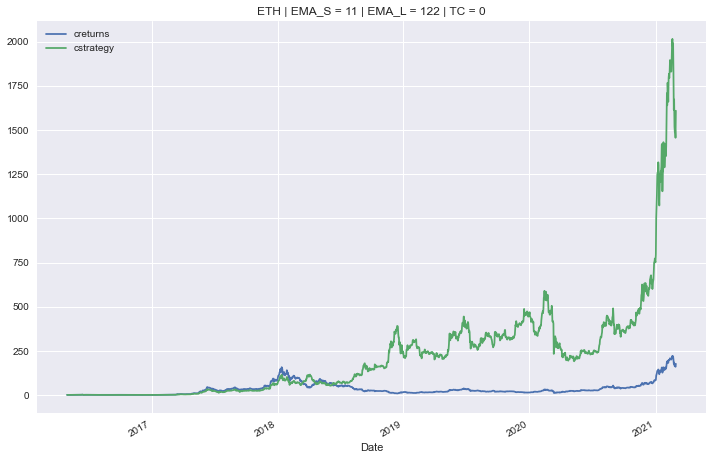

In [31]:
tester_E.plot_results()

In [33]:
tester_E.test_strategy()
# 14 trades

(1609.12761,
 1432.254545,
 0.0    1747
 2.0      14
 Name: trades, dtype: int64)

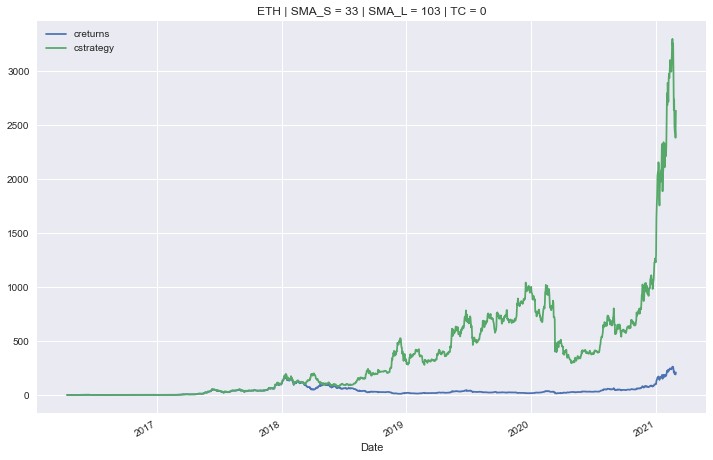

In [32]:
#plotando o otimizado para SMA. Melhor ou pior?
tester_S.plot_results()

### Backtesting & Forward Testing

In [34]:
train_E = EMABacktester("ETH", 50, 200, "2016-01-01", "2019-10-01", 0)

In [35]:
train_E.optimize_parameters((9, 100, 1), (100, 300, 1))

(array([ 11., 122.]), 330.761208)

In [38]:
train_E.test_strategy()
#número de trades...

(330.761208,
 310.333864,
 0.0    1238
 2.0      11
 Name: trades, dtype: int64)

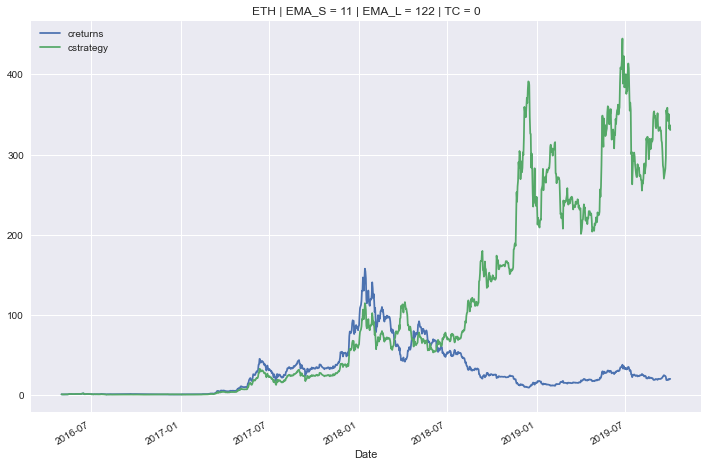

In [36]:
train_E.plot_results()

In [45]:
#AQUI.......... #sma curta e longa tomados dos melhores resultados do treinamento (acima)

tester_O2 = EMABacktester("ETH", 11, 122, "2019-10-01", "2021-03-01", 0)

In [46]:
tester_O2.test_strategy()

(4.501079,
 -4.184013,
 0.0    389
 2.0      2
 Name: trades, dtype: int64)

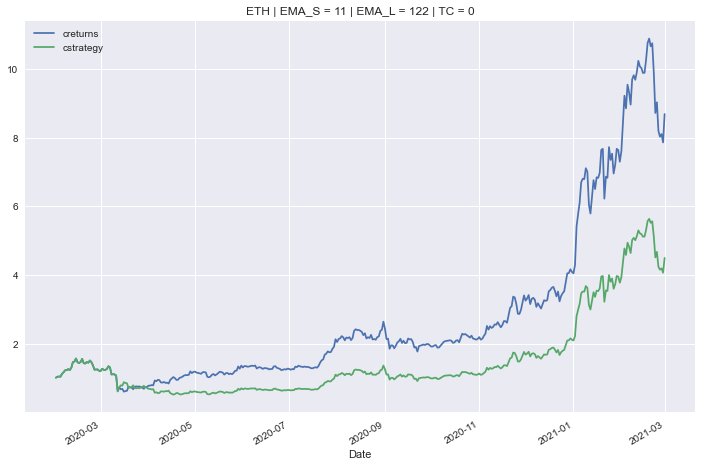

In [47]:
tester_O2.plot_results()
#o resultado da estratégia foi melhor ou pior?

In [48]:
tester_O2.optimize_parameters((9, 100, 1), (100, 300, 1))

(array([  9., 199.]), 8.542736)

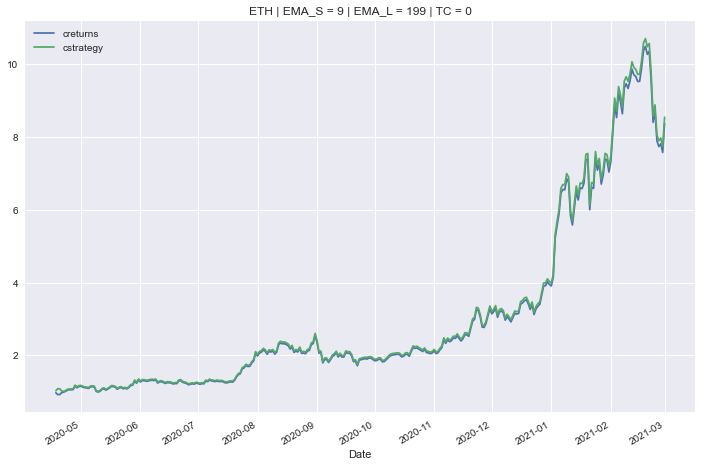

In [49]:
tester_O2.plot_results()

In [52]:
tester_O2.test_strategy()
#apenas um trade
#isto é, a estratégia não era o melhor. Só um trade de todas as possibilidaades
#"usar outra estratégia "

(8.542736,
 0.171465,
 0.0    313
 2.0      1
 Name: trades, dtype: int64)

In [51]:
#mesmo aqui. como os trades são menos frequentes, pelo fato de quebrar o data set, descontinuou algum bom trade e deveria ser revisto a partir do ponto de descontinuidade

# SMA x EMA Optimizer

In [39]:
class SMAEMABacktester(): 
    ''' Class for the vectorized backtesting of SMA/EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA: int
        time window in days for SMA
    EMA: int
        time window in days for EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA/EMA parameters
        
    test_strategy:
        runs the backtest for the SMA/EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SAM/EMA parameters
    '''
    
    def __init__(self, symbol, SMA, EMA, start, end, tc):
        self.symbol = symbol
        self.SMA = SMA
        self.EMA = EMA
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMAEMABacktester(symbol = {}, SMA = {}, EMA = {}, start = {}, end = {})".format(self.symbol, self.SMA, self.EMA, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA"] = raw["price"].rolling(self.SMA).mean() 
        raw["EMA"] = raw["price"].ewm(span = self.EMA, min_periods = self.EMA).mean() 
        self.data = raw
        
    def set_parameters(self, SMA = None, EMA = None):
        ''' Updates SMA/EMA parameters and resp. time series.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean() 
        if EMA is not None:
            self.EMA = EMA
            self.data["EMA"] = self.data["price"].ewm(span = self.EMA, min_periods = self.EMA).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA"] > data["SMA"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA = {} | EMA = {} | TC = {}".format(self.symbol, self.SMA, self.EMA, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMAEMA):
        ''' Updates SMA/EMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMAEMA: tuple
            SMA/EMA parameter tuple
        '''
        self.set_parameters(int(SMAEMA[0]), int(SMAEMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA_range, EMA_range):
        ''' Finds global maximum given the SMA/EMA parameter ranges.

        Parameters
        ==========
        SMA_range, EMA_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA_range, EMA_range), finish=None)
        return opt, -self.update_and_run(opt)

In [40]:
tester_SE = SMAEMABacktester("ETH", 50, 50, "2016-01-01", "2021-03-01", 0)
tester_SE

SMAEMABacktester(symbol = ETH, SMA = 50, EMA = 50, start = 2016-01-01, end = 2021-03-01)

In [41]:
tester_SE.test_strategy()

(74.862051,
 -255.392075,
 0.0    1788
 2.0      45
 Name: trades, dtype: int64)

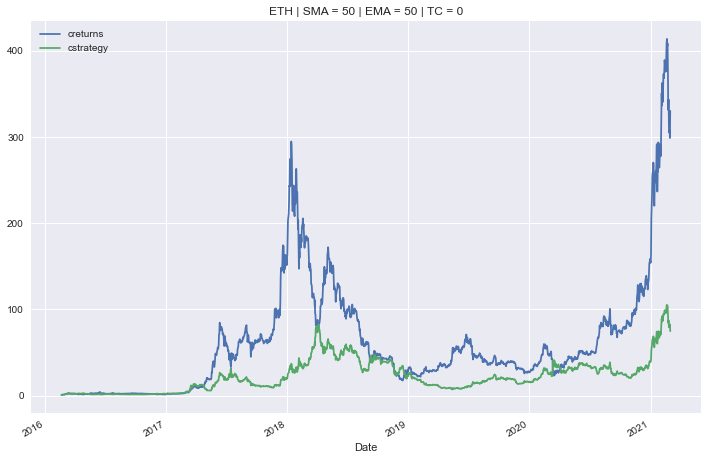

In [42]:
# SMA x EMa 50,50 não funciona
tester_SE.plot_results()

In [43]:
tester_SE.optimize_parameters((9, 300, 1), (9, 300, 1))

(array([24., 20.]), 254589.485393)

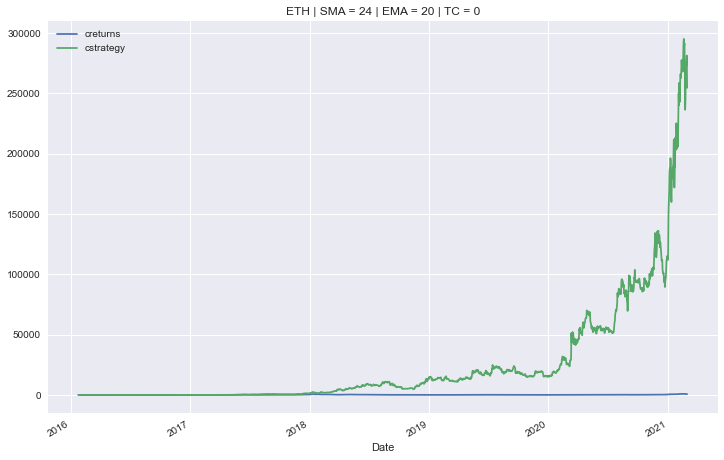

In [44]:
tester_SE.plot_results()

In [53]:
tester_SE.test_strategy()
#77 trades 

(254589.485393,
 253858.723393,
 0.0    1782
 2.0      77
 Name: trades, dtype: int64)

### Backtesting & Forward Testing

In [54]:
train_SE = SMAEMABacktester("ETH", 50, 50, "2016-01-01", "2019-10-01", 0)

In [55]:
train_SE.optimize_parameters((9, 300, 1), (9, 300, 1))

(array([26., 23.]), 24422.385811)

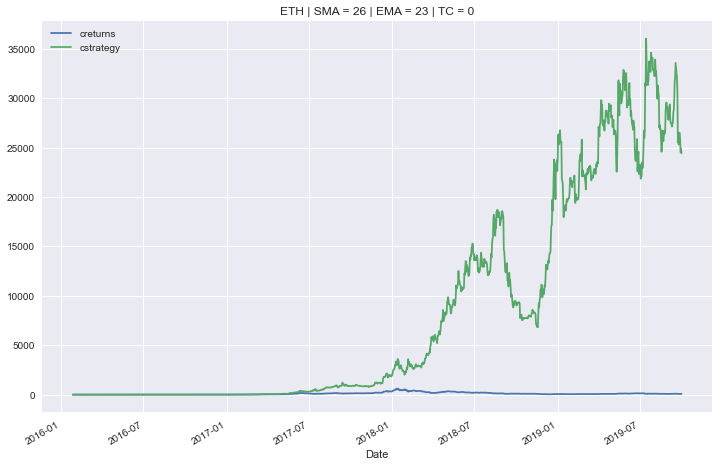

In [56]:
train_SE.plot_results()

In [61]:
train_SE.test_strategy()

(24422.385811,
 24343.000427,
 0.0    1298
 2.0      47
 Name: trades, dtype: int64)

In [62]:
#AQUI.......... #sma curta e longa tomados dos melhores resultados do treinamento (acima)

tester_O3 = SMAEMABacktester("ETH", 26, 23, "2019-10-01", "2021-03-01", 0)

In [63]:
tester_O3.test_strategy()

(8.190225,
 -0.302441,
 0.0    463
 2.0     24
 Name: trades, dtype: int64)

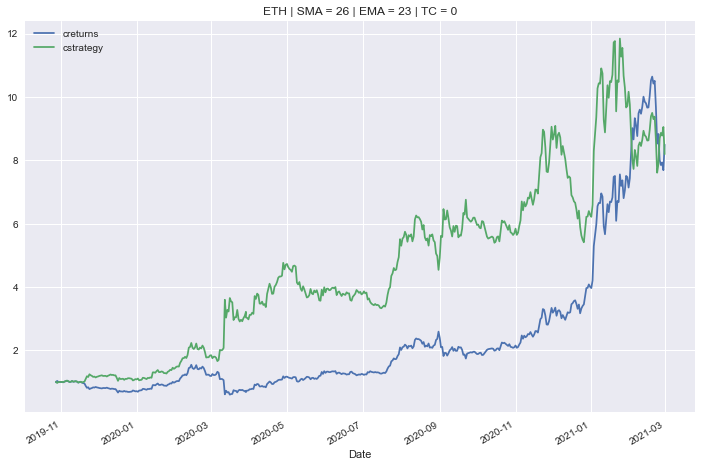

In [64]:
tester_O3.plot_results()
#o resultado da estratégia foi melhor ou pior?
#resultado foi até bom considerando que foram realizados 24 trades no período.
#qual o numero de trades na versão otimizada?

In [65]:
tester_O3.optimize_parameters((9, 300, 1), (9, 300, 1))

(array([22., 22.]), 29.497956)

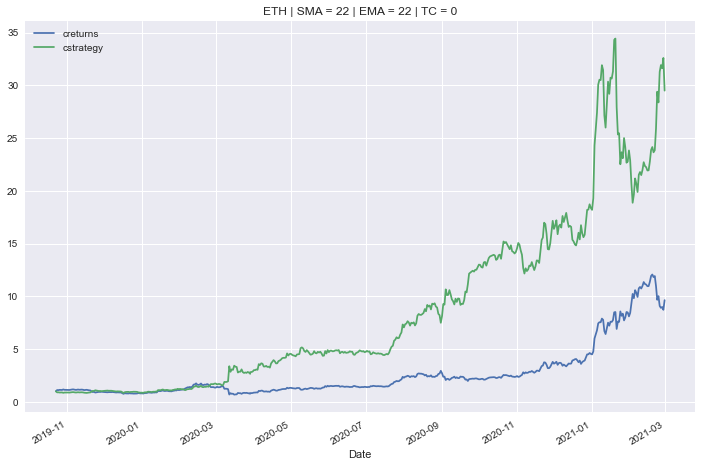

In [66]:
tester_O3.plot_results()

In [67]:
tester_O3.test_strategy()

(29.497956,
 19.863222,
 0.0    465
 2.0     26
 Name: trades, dtype: int64)

In [68]:
#22, 22 foi amaprado por bom número de trades ebom retorno desde final de 2019